In [15]:
import torch
import torch.nn as nn
import torchvision as tv

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

In [119]:
def get_mnist_ds(is_train:bool):
    return tv.datasets.MNIST(root = Path('mnistdata'),
                             train = is_train,
                             transform = tv.transforms.ToTensor(),
                             target_transform = None,
                             download = True
                            )

torch.Size([28, 28])


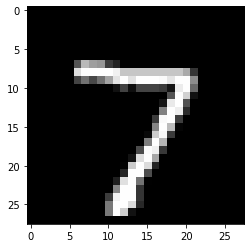

torch.Size([28, 28])


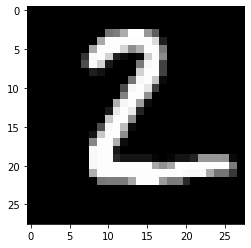

torch.Size([28, 28])


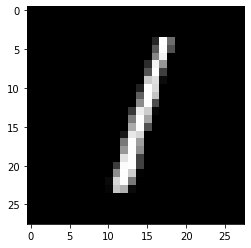

torch.Size([28, 28])


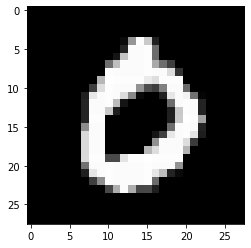

In [120]:
for i, pic in enumerate(x):
    print(pic[0][0].shape)
    plt.imshow(pic[0][0],cmap='gray')
    plt.show()
    if i>=3: break

In [121]:
def get_mnist_ds_loader(batch_size):
        train_ds = get_mnist_ds(is_train = True)
        valid_ds = get_mnist_ds(is_train = False)
        
        return (torch.utils.data.DataLoader(train_ds, batch_size, shuffle = True),
                torch.utils.data.DataLoader(valid_ds, 2*batch_size, shuffle = False))
    

In [122]:
train_dl, valid_dl = get_mnist_ds_loader(32)

In [123]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [124]:
train_dl.dataset.data.shape

torch.Size([60000, 28, 28])

torch.Size([32, 1, 28, 28])


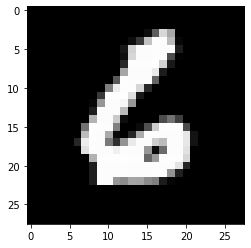

torch.Size([32, 1, 28, 28])


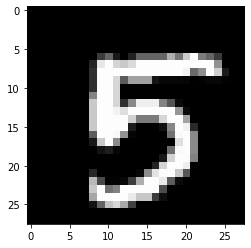

torch.Size([32, 1, 28, 28])


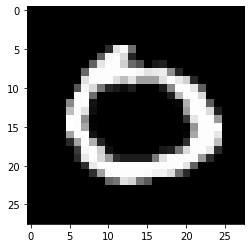

torch.Size([32, 1, 28, 28])


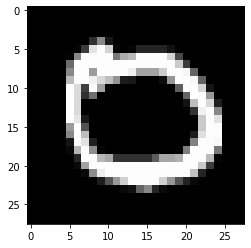

torch.Size([32, 1, 28, 28])


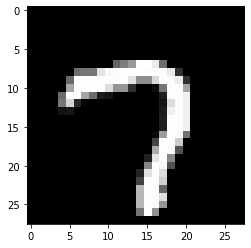

In [139]:
for i, x in enumerate(train_dl):
    print(x[0].shape)
    plt.imshow(x[0][0][0],cmap='gray')
    plt.show()
    if i>3 : break